In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

## Data Loading

In [2]:
# Datatypes of each column
dtypes = {
    'authorized_flag':      'str',     # Y or N
    'card_id':              'str',     # 325540 unique values
    'city_id':              'int16',   # -1 then 1 to 347 (is -1 supposed to be nan?)
    'category_1':           'str',     # Y or N
    'installments':         'int8',    # -25, then -1 thru 12 (-1 supposed to be nan?)
    'category_3':           'str',     # A, B, C, and nan
    'merchant_category_id': 'int16',   # 2 to 891
    'merchant_id':          'str',     # lots of unique ones here and nans
    'month_lag':            'int8',    # -13 thru 0
    'purchase_amount':      'float32', # min: -0.746, med: -0.699, max: 11269.667
    'purchase_date':        'str',     # YYYY-MM-DD hh:mm:ss
    'category_2':           'float32', # 1 thru 5 and nan
    'state_id':             'int8',    # -1 then 1 thru 24
    'subsector_id':         'int8'     # 1 thru 41
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)

# Convert time column
hist_trans['purchase_date'] = hist_trans['purchase_date'].str.slice(0, 19)
hist_trans['purchase_date'] = pd.to_datetime(hist_trans['purchase_date'],
                                             utc=True,
                                             format='%Y-%m-%d %H:%M:%S')

In [3]:
hist_trans.sample(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
4794768,Y,C_ID_896240f30f,174,N,0,A,222,M_ID_6c8d8dd463,-1,-0.737892,2017-08-05 09:51:10+00:00,1.0,9,21
17917400,Y,C_ID_445ecc492e,158,N,1,B,195,M_ID_4f2dfc4654,-4,-0.691610,2017-10-24 00:00:00+00:00,1.0,15,34
24714857,N,C_ID_660530ed96,69,N,0,A,367,M_ID_6ac6d049a1,-1,-0.719184,2017-11-22 02:26:01+00:00,1.0,9,16
11924326,Y,C_ID_7ee7d8f0aa,114,N,0,A,367,M_ID_2fb48d363c,-5,-0.514403,2017-07-11 17:43:42+00:00,4.0,4,16
8820199,Y,C_ID_839bef9ee9,247,N,0,A,80,M_ID_4f44062882,-6,-0.705885,2017-08-08 23:04:43+00:00,5.0,5,37
14688415,Y,C_ID_fec62c1679,88,N,0,A,560,M_ID_6cb0602e94,-1,-0.736014,2018-01-31 09:09:35+00:00,1.0,16,34
22069729,Y,C_ID_cec8a4b357,286,N,0,A,437,M_ID_31396dd0c9,0,-0.685374,2018-02-03 16:01:23+00:00,3.0,3,15
18780473,Y,C_ID_a822064410,156,N,3,C,222,M_ID_11b487b877,-7,-0.573352,2017-07-24 16:04:43+00:00,3.0,7,21
4114568,Y,C_ID_636daae7a7,302,N,0,A,80,M_ID_146bc313dc,-3,-0.708590,2017-11-02 15:23:48+00:00,3.0,7,37
25345094,Y,C_ID_c1e2664480,69,N,1,B,561,M_ID_50f575c681,-3,-0.697771,2017-11-18 02:02:43+00:00,1.0,9,7


## EDA

Only `category_3`, `merchant_id`, and `category_2` have any `NaN` values.

In [4]:
# Print info about each col
info_df = pd.DataFrame(index=hist_trans.keys(),
                       columns=['Dtype', 'Nulls', 'Info'])
for name, col in hist_trans.items():
    t_null = col.isnull().sum()
    t_dtype = col.dtype.name
    if t_dtype == 'object':
        uniques = col.unique()
        if len(uniques) < 10:
            info_str = 'Unique elements: ' + str(uniques)
        else:
            info_str = '%d unique elements' % len(uniques)
    elif 'int' in t_dtype or 'float' in t_dtype:
        info_str = ('min: ' + str(col.min()) +
                    '  median: ' + str(col.median()) +
                    '  max: ' + str(col.max()))
    else: #should be the datetime col
        info_str = ('min: ' + str(col.min()) +
                    '  max: ' + str(col.max()))
    info_df.loc[name, 'Dtype'] = t_dtype
    info_df.loc[name, 'Nulls'] = t_null
    info_df.loc[name, 'Info'] = info_str

info_df

,Dtype,Nulls,Info
authorized_flag,object,0,Unique elements: ['Y' 'N']
card_id,object,0,325540 unique elements
city_id,int16,0,min: -1 median: 90.0 max: 347
category_1,object,0,Unique elements: ['N' 'Y']
installments,int8,0,min: -25 median: 0.0 max: 12
category_3,object,178159,Unique elements: ['A' 'B' 'C' nan]
merchant_category_id,int16,0,min: -1 median: 454.0 max: 891
merchant_id,object,138481,326312 unique elements
month_lag,int8,0,min: -13 median: -4.0 max: 0
purchase_amount,float32,0,min: -0.7469078 median: -0.6883494853973389 ...


Notes on each column in `historical_transactions.csv`:

**card_id**: 
Card identifier

**month_lag**: 
month lag to reference date

**purchase_date**: 
Purchase date

**authorized_flag**: 
Y' if approved, 'N' if denied.  Not sure how these payments count if they were denied? But oh well.

**category_3**: 
anonymized category

**installments**: 
number of installments of purchase

**category_1**: 
anonymized category

**merchant_category_id**: 
Merchant category identifier (anonymized )

**subsector_id**: 
Merchant category group identifier (anonymized )

**merchant_id**: 
Merchant identifier (anonymized)

**purchase_amount**: 
Normalized purchase amount

**city_id**: 
City identifier (anonymized )

**state_id**: 
State identifier (anonymized )

**category_2**: 
anonymized category


Plotting the distributions of each column:

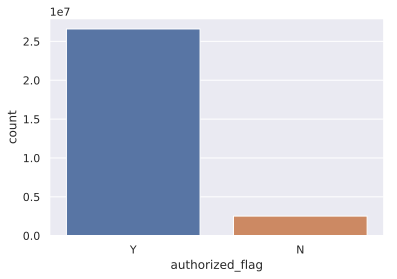

In [5]:
# authorized_flag
sns.countplot(x='authorized_flag', data=hist_trans)
plt.show()

In [6]:
# card_id has 325540 unique values

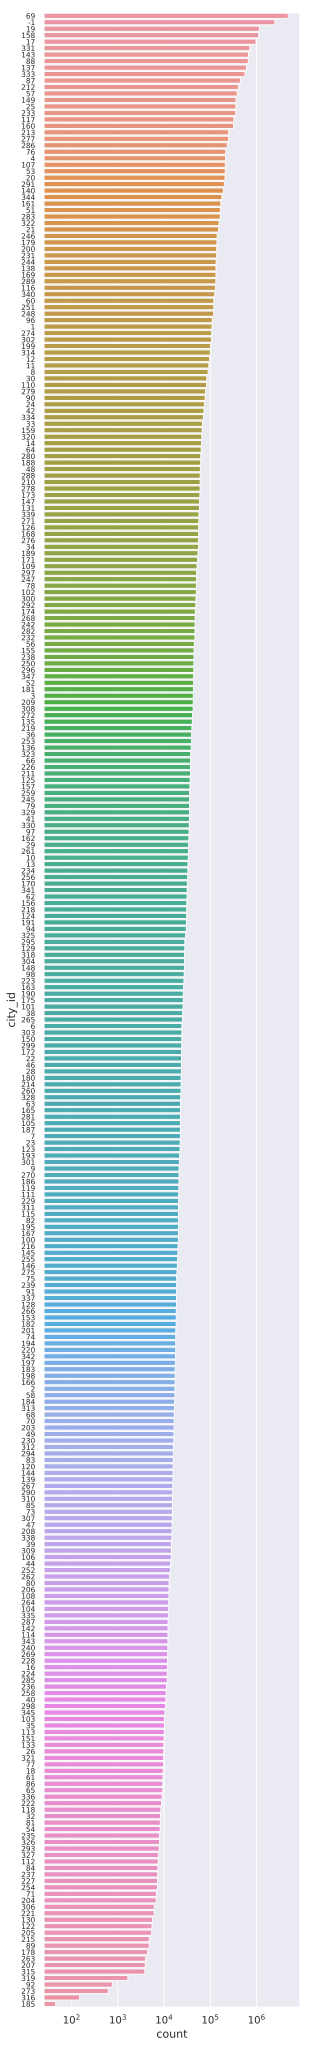

In [7]:
# city_id
plt.figure(figsize=(5, 40))
sns.countplot(y='city_id', data=hist_trans,
              order=hist_trans['city_id'].value_counts().index)
plt.yticks(fontsize=8)
plt.gca().set(xscale='log')
plt.show()

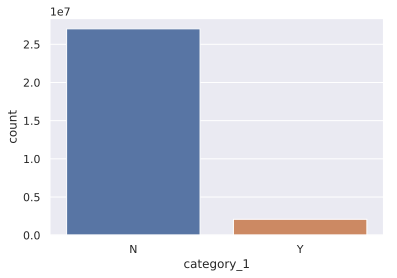

In [8]:
# category_1
sns.countplot(x='category_1', data=hist_trans)
plt.show()

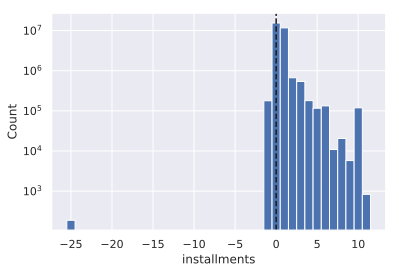

In [9]:
# installments
plt.hist(hist_trans['installments'], bins=np.arange(-25.5, 12.5, 1.0))
plt.axvline(x=0, color='k', linestyle='--')
plt.ylabel('Count')
plt.xlabel('installments')
plt.yscale('log', nonposy='clip')
plt.show()

In [10]:
# TODO: what does it mean to have negative or zero number of installments?
# maybe just treat those as nans?  Or add indicator col?

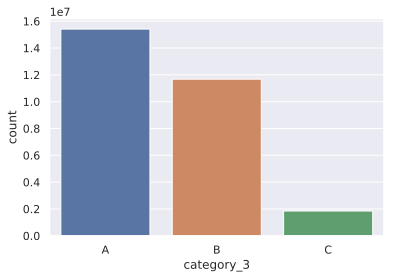

In [11]:
# category_3
sns.countplot(x='category_3', data=hist_trans)
plt.show()

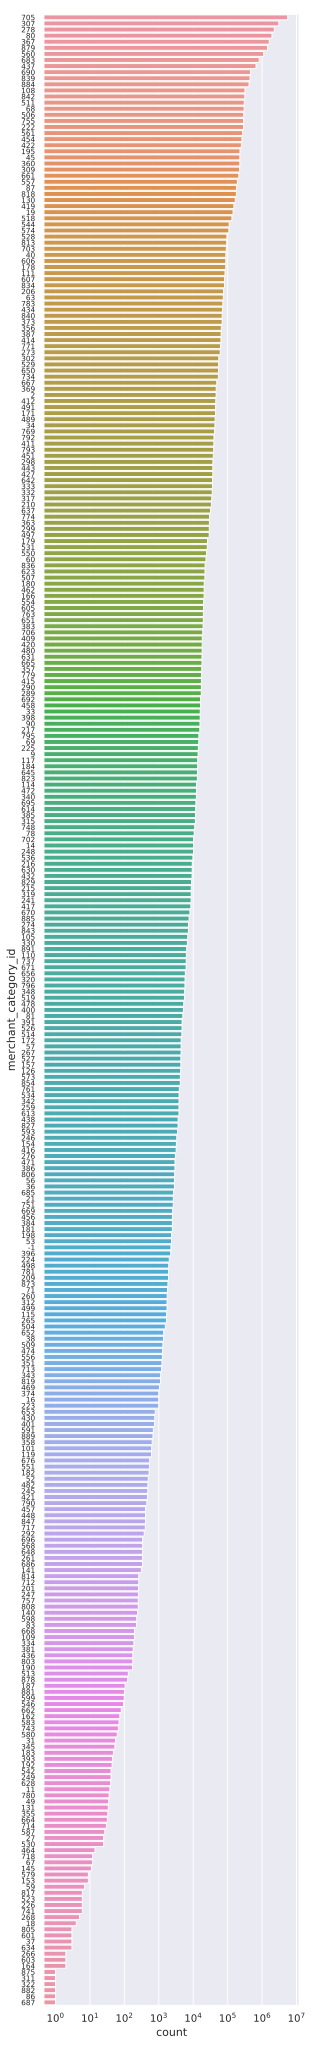

In [12]:
# merchant_category_id
plt.figure(figsize=(5, 40))
sns.countplot(y='merchant_category_id', data=hist_trans,
              order=hist_trans['merchant_category_id'].value_counts().index)
plt.yticks(fontsize=8)
plt.gca().set(xscale='log')
plt.show()

In [13]:
# merchant_id has 326312 unique values

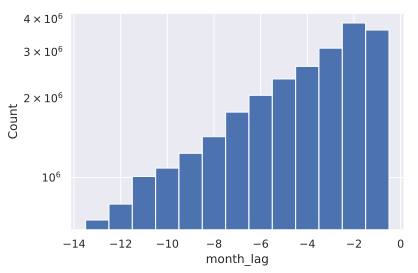

In [14]:
plt.hist(hist_trans['month_lag'], bins=np.arange(-13.5, 0.5, 1.0))
plt.ylabel('Count')
plt.xlabel('month_lag')
plt.yscale('log')
plt.show()

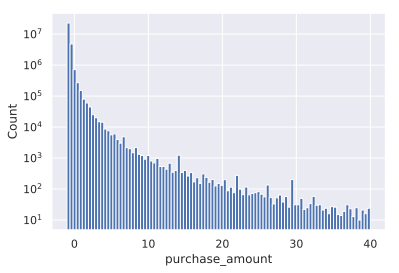

In [15]:
# purchase_amount
plt.hist(hist_trans['purchase_amount'], bins=np.linspace(-1, 40, 100))
plt.ylabel('Count')
plt.xlabel('purchase_amount')
plt.yscale('log')
plt.show()

# NOTE that there are values up to 11269.667!
# some purchase amounts are <0 because the values are normalized

In [16]:
# purchase_date goes from 2017-01-01 00:00:08  to  2018-02-28 23:59:51

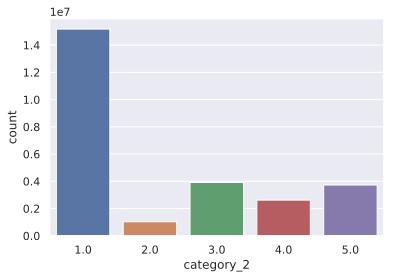

In [17]:
# category_2
sns.countplot(x='category_2', data=hist_trans)
plt.show()

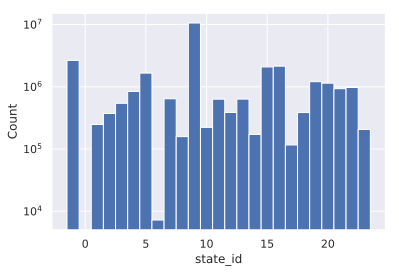

In [18]:
plt.hist(hist_trans['state_id'], bins=np.arange(-1.5, 24.5, 1.0))
plt.ylabel('Count')
plt.xlabel('state_id')
plt.yscale('log')
plt.show()

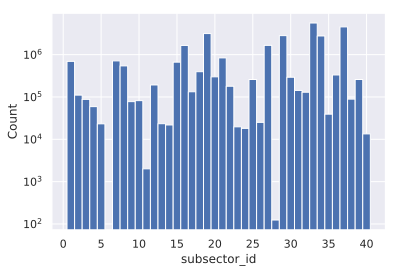

In [19]:
# subsector_id
plt.hist(hist_trans['subsector_id'], bins=np.arange(0.5, 41.5, 1.0))
plt.ylabel('Count')
plt.xlabel('subsector_id')
plt.yscale('log', nonposy='clip')
plt.show()

## Merging `historical_transactions.csv` and `new_merchant_transactions.csv`

Looks like `historical_transactions.csv` and `new_merchant_transactions.csv` have identical columns.  Some people have suggested just merging them.

In [20]:
# Datatypes of each column
dtypes = {
    'authorized_flag':      'str',     # Y or N
    'card_id':              'str',     # 325540 unique values
    'city_id':              'int16',   # -1 then 1 to 347 (is -1 supposed to be nan?)
    'category_1':           'str',     # Y or N
    'installments':         'int8',    # -25, then -1 thru 12 (-1 supposed to be nan?)
    'category_3':           'str',     # A, B, C, and nan
    'merchant_category_id': 'int16',   # 2 to 891
    'merchant_id':          'str',     # lots of unique ones here and nans
    'month_lag':            'int8',    # -13 thru 0
    'purchase_amount':      'float32', # min: -0.746, med: -0.699, max: 11269.667
    'purchase_date':        'str',     # YYYY-MM-DD hh:mm:ss
    'category_2':           'float32', # 1 thru 5 and nan
    'state_id':             'int8',    # -1 then 1 thru 24
    'subsector_id':         'int8'     # 1 thru 41
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)

First off, are there duplicate rows in either individually?  And if not do we get duplicates when we merge them (i.e. are there entries in `new_merchant_transactions.csv` which are also in `historical_transactions.csv`?).

In [21]:
print("Number of duplicate rows in merchants.csv: %d" % hist_trans.duplicated().sum())
print("Number of duplicate rows in merchants.csv: %d" % new_trans.duplicated().sum())

trans = pd.concat([hist_trans, new_trans])
del hist_trans, new_trans

print("Number of duplicate rows in merged df: %d" % trans.duplicated().sum())

Number of duplicate rows in merchants.csv: 0
Number of duplicate rows in merchants.csv: 0
Number of duplicate rows in merged df: 0


OK, good - no duplicates so we don't need to worry about that there.

## Connecting `{historical,new_merchant}_transactions.csv` and `merchants.csv`

`category_1`, `category_2`, `city_id`, and `state_id` are in both `{historical,new_merchant}_transactions.csv` AND in `merchants.csv`.  Will have to see if those are values of the merchants in both, or if they are properties of the merchants in `merchants.csv` and different properties of the transactions in `*transactions.csv`.  For example, is the `state_id` in `merchants.csv` where the merchant's headquarters is, while `state_id` in `*transactions.csv` means the state where the transaction occurred?  Or does it always mean the merchant's state?

However, `category_3` is only in `*transactions.csv`, while `category_4` is only in `merchants.csv`.  So presumably `category_3` is a property of each transaction, while `category_4` is a property of each merchant.

Also, `merchant_category_id`, `subsector_id` are in both `*transactions.csv` AND in `merchants.csv`.  Presumaby they have the same value, but should double-check that!  What I mean is, for any entry in `*transactions.csv`, if you look up that `merchant_id` in `merchants.csv`, the `merchant_category_id` there should match the one for your entry in `*transactions.csv`.

Do `category_1`, `category_2`, `city_id`,  `state_id`, `merchant_category_id`, and `subsector_id` values match between `merchants.csv` and entries in `{historical,new_merchant}_transactions.csv` which have the corresponding `merchant_id`?

In [22]:
# Only load parts of tables that you need

# Datatypes of each column
dtypes = {
    'city_id':              'int16',   # -1 then 1 to 347 (is -1 supposed to be nan?)
    'category_1':           'str',     # Y or N
    'merchant_category_id': 'int16',   # 2 to 891
    'merchant_id':          'str',     # lots of unique ones here and nans
    'category_2':           'float32', # 1 thru 5 and nan
    'state_id':             'int8',    # -1 then 1 thru 24
    'subsector_id':         'int8'     # 1 thru 41
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)
merchants = pd.read_csv('../input/merchants.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)

# Merge new_merchant and historical transactions
trans = pd.concat([hist_trans, new_trans])
del hist_trans
del new_trans

BTW it looks like there ARE duplicate rows in the merchants table, and one duplicate `merchant_id` w/ different value in its row from the first.

In [23]:
print("Number of duplicate merchant_ids: %d" % merchants['merchant_id'].duplicated().sum())
print("Number of duplicate rows in merchants.csv: %d" % merchants.duplicated().sum())
#merchants.loc[merchants.duplicated(), :].sort_values('merchant_id') #show the rows
merchants.drop_duplicates(inplace=True) #remove the duplicate rows

Number of duplicate merchant_ids: 63
Number of duplicate rows in merchants.csv: 62


First, let's check that in the transactions df, there's only one unique value for each column for the same `merchant_id`:

In [24]:
%%time

# For each column, find the number of merchant_ids which have >1 unique value for that column
gbo = trans.groupby('merchant_id')
print('Column\tNumber of non-unique')
for col in trans:
    if col == 'merchant_id': continue
    print(col, (gbo[col].nunique() > 1).sum())
    # TODO: oh, have to correct for nans...  But city_id doesn't have any nans so i guess there really are just duplicates...?
    
# Note that only category_2 has ANY nans...

Column	Number of non-unique
city_id 25207
category_1 3494
merchant_category_id 82636
category_2 7844
state_id 17435
subsector_id 44373
CPU times: user 4min 2s, sys: 1.9 s, total: 4min 4s
Wall time: 4min 3s


Uh...  ALL those columns have many `merchant_id`s which have different values...?

Also note there's one merchant in merchants which isn't in `*transactions.csv`:

In [25]:
print('Num merchants in merchants.csv: ', merchants.shape[0])
print('Num merchants in transactions data: ', len(gbo))

Num merchants in merchants.csv:  334634
Num merchants in transactions data:  334633


Then, we can check that those values match up to the values for that `merchant_id` in `merchants.csv`:

In [26]:
# Join trans w/ merchants on merchant_id
cols = trans.columns
df = trans.merge(merchants, how='outer', on='merchant_id', suffixes=('', '_merchants'))
del trans
del merchants

# Check that all city_id==city_id_merchants, category_1==category_1_merchants, etc
print('Number of entries: ', df.shape[0])
print('Column\tNum mismatches between merchants and transactions')
for col in cols:
    if 'merchant_id' in col: continue
    sames = ((df[col] == df[col+'_merchants']) | 
             (df[col].isnull() & df[col+'_merchants'].isnull())).sum()
    print(col, df.shape[0]-sames)

Number of entries:  31075399
Column	Num mismatches between merchants and transactions
city_id 8465844
category_1 2229967
merchant_category_id 4242706
category_2 3337514
state_id 3448287
subsector_id 3018116


Egad.  That's a pretty hefty portion of the data... I feel like `merchant_category_id` and `subsector_id` should at least match?

## Data Cleaning

In [27]:
# TODO: cut off crazy high values of purchase_amount?